In [3]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..") # Adds higher directory to python modules path.

from src.data.htr_datamodule import HTRDataModule
from src.data.htr_datamodule import HTRDataset

# import v2 torchvision
from torchvision.transforms import v2
import torchvision

import src



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Instantiate dataset for training and validation

In [3]:
# Instantiate manually the datasets
tokenizer = src.data.components.tokenizers.CharTokenizer(model_name="char_tokenizer", vocab_file="../data/vocab.txt")

# IAM dataset
with open("../data/htr_datasets/IAM/splits/train.txt", "r") as f:
  setfiles = f.read().splitlines()
  
read_data = src.data.data_utils.read_data_IAM
images_paths, words = read_data("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", setfiles)
htr_dataset = HTRDataset(images_paths, words, binarize=True, transform=v2.Compose([v2.ToTensor()]))

VOCAB SIZE TOKENIZER: 94
COMPLETE VOCAB: {'[BOS]': 0, '[EOS]': 1, '[PAD]': 2, '[UNK]': 3, ' ': 4, '!': 5, '"': 6, '#': 7, '%': 8, '&': 9, "'": 10, '(': 11, ')': 12, '*': 13, '+': 14, ',': 15, '-': 16, '.': 17, '/': 18, '0': 19, '1': 20, '2': 21, '3': 22, '4': 23, '5': 24, '6': 25, '7': 26, '8': 27, '9': 28, ':': 29, ';': 30, '<': 31, '=': 32, '>': 33, '?': 34, 'A': 35, 'B': 36, 'C': 37, 'D': 38, 'E': 39, 'F': 40, 'G': 41, 'H': 42, 'I': 43, 'J': 44, 'K': 45, 'L': 46, 'M': 47, 'N': 48, 'O': 49, 'P': 50, 'Q': 51, 'R': 52, 'S': 53, 'T': 54, 'U': 55, 'V': 56, 'W': 57, 'X': 58, 'Y': 59, 'Z': 60, '[': 61, ']': 62, '_': 63, 'a': 64, 'b': 65, 'c': 66, 'd': 67, 'e': 68, 'f': 69, 'g': 70, 'h': 71, 'i': 72, 'j': 73, 'k': 74, 'l': 75, 'm': 76, 'n': 77, 'o': 78, 'p': 79, 'q': 80, 'r': 81, 's': 82, 't': 83, 'u': 84, 'v': 85, 'w': 86, 'x': 87, 'y': 88, 'z': 89, '{': 90, '}': 91, '£': 92, '€': 93}


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


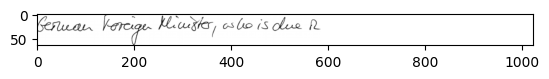

In [4]:
# Create dataloader for iam
dl_train = torch.utils.data.DataLoader(
  htr_dataset, 
  batch_size=64, 
  shuffle=True, 
  num_workers=4, 
  pin_memory=True,
  collate_fn=lambda batch: src.data.data_utils.collate_fn(
    batch,
    img_size=(64,1024),
    text_transform=tokenizer.prepare_text
  )
)

for i, batch in enumerate(dl_train):
  if i == 0:
    images, targets, _ = batch
    # print(images.shape)
    plt.imshow(images[0].permute(1, 2, 0))
  break

In [5]:
# Generic functions for reading data and create a dataloader

def read_dataset(images_path, sequences_path, split_path, read_data, tokenizer, transform=v2.Compose([v2.ToTensor()])):
  with open(split_path, "r") as f:
    setfiles = f.read().splitlines()
  
  images_paths, words = read_data(images_path, sequences_path, setfiles)
  htr_dataset = HTRDataset(images_paths, words, binarize=True, transform=transform)

  # Create dataloader for iam
  dl = torch.utils.data.DataLoader(
    htr_dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True,
    collate_fn=lambda batch: src.data.data_utils.collate_fn(
      batch,
      img_size=(64,1024),
      text_transform=tokenizer.prepare_text
    )
  )
  return dl

## Create AE architecture

In [12]:
class Encoder(nn.Module):
  # Convolutional Encoder for HTR
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=(3,3), padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1)
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.relu = nn.LeakyReLU()
    self.fc = nn.Linear(128*4*64, 512)
  
  def forward(self, x):
    # print(f'Encoder input shape: {x.shape}')
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    # print(x.shape)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    # print(x.shape)
    x = self.relu(self.conv3(x))
    x = self.pool(x)
    # print(x.shape)
    x = self.relu(self.conv4(x))
    x = self.pool(x)
    # print(x.shape)
    x = x.view(x.size(0), -1) # Flatten operation
    # print(x.shape)
    x = self.fc(x)
    # print(x.shape)
    return x
  
  
class Decoder(nn.Module):
  # Convolutional Decoder for HTR
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc = nn.Linear(512, 128*4*64)
    # Deconvolutions (transposed convolutions)
    self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=(3,3), stride=(2,2), padding=0)
    self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=(3,3), stride=(2,2), padding=1)
    self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=(3,3), stride=(2,2), padding=1)
    self.deconv4 = nn.ConvTranspose2d(16, 3, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=0)
    self.relu = nn.LeakyReLU()
    self.sigmoid = nn.Sigmoid()
    
  def forward(self, x):
    # print(f'Decoder input shape: {x.shape}')
    x = self.fc(x)
    # print(f'x.shape: {x.shape}')
    x = x.view(x.size(0), 128, 4, 64)
    # print(f'x.shape (after view): {x.shape}')
    x = self.relu(self.deconv1(x))
    # print(f'x.shape: {x.shape}')
    x = self.relu(self.deconv2(x))
    # print(f'x.shape: {x.shape}')
    x = self.relu(self.deconv3(x))
    # print(f'x.shape: {x.shape}')
    x = self.relu(self.deconv4(x))
    # print(f'x.shape: {x.shape}')
    
    x = torch.narrow(x, 2, 0, 64)
    x = torch.narrow(x, 3, 0, 1024)
    x = self.sigmoid(x)
    
    return x
  
  
class AE(nn.Module):
  # Complete Autoencoder (AE) trained to reconstruct images
  def __init__(self):
    super(AE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    
  def forward(self, x):
    h = self.encoder(x)
    x = self.decoder(h)
    return x
  

  

In [7]:
dl_train = read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/train.txt", src.data.data_utils.read_data_IAM, tokenizer, 
                        transform=v2.Compose(
                          [
                            torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.ElasticTransform(5.0, 5.0)], p=0.5),
                            torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.RandomAffine(degrees=1, translate=(0.01, 0.05), shear=[-1, 1, -1, 1], fill=255)], p=0.5),
                            torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.RandomPerspective(distortion_scale=0.1, p=1.0, fill=255)], p=0.5),
                            torchvision.transforms.v2.ToTensor()
                          ]))
dl_val = read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/val.txt", src.data.data_utils.read_data_IAM, tokenizer, 
                      transform=v2.Compose([v2.ToTensor()]))

In [ ]:
# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AE()
model = model.to(device)

# import tqdm
from tqdm import tqdm

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
  
print(f'The model has {count_parameters(model):,} trainable parameters')


# Let's test the forward pass
print(images.shape)

output = model(images.to(device))
output_enc = model.encoder(images.to(device))
print(images.shape, output.shape, output_enc.shape)

# Loss function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_loss_val = 1e10

# Training loop
n_epochs = 100

for epoch in range(n_epochs):
  print(f'Epoch {epoch}')
  total_loss_epoch = 0.0
  model.train()
  for i, batch in tqdm(enumerate(dl_train), total=len(dl_train)):
    images, targets, _ = batch
    images = images.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, images)
    total_loss_epoch += loss.item()
    
    loss.backward()
    optimizer.step()
    
    if i % 1000 == 0:
      print(f'Epoch {epoch}, Loss: {loss.item()}')
      
  print(f'Epoch {epoch}, Loss: {loss.item()}. Total loss: {total_loss_epoch}')

  # Validation
  model.eval()
  total_loss_val = 0.0
  with torch.no_grad():
    for i, batch in enumerate(dl_val):
      images, targets, _ = batch
      images = images.to(device)
      outputs = model(images)
      loss = criterion(outputs, images)
      total_loss_val += loss.item()
      
  print(f'Validation loss: {total_loss_val}')
  
  if best_loss_val > total_loss_val:
    best_loss_val = total_loss_val
    torch.save(model.state_dict(), '../checkpoints/best_ae_iam.ckpt')
    print('Model saved')
  



In [ ]:

# Save model checkpoint with .ckpt extension
torch.save(model.state_dict(), '../checkpoints/autoencoder.ckpt')

In [16]:
# Load model from checkpoint``
model = AE()
model.load_state_dict(torch.load('../checkpoints/autoencoder.ckpt'))
print(model)

/tmp/ipykernel_788895/2098111746.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../checkpoints/autoencoder.ckpt'))


AE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (fc): Linear(in_features=32768, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=512, out_features=32768, bias=True)
    (deconv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (deconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (deconv3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (deconv4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): LeakyR

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


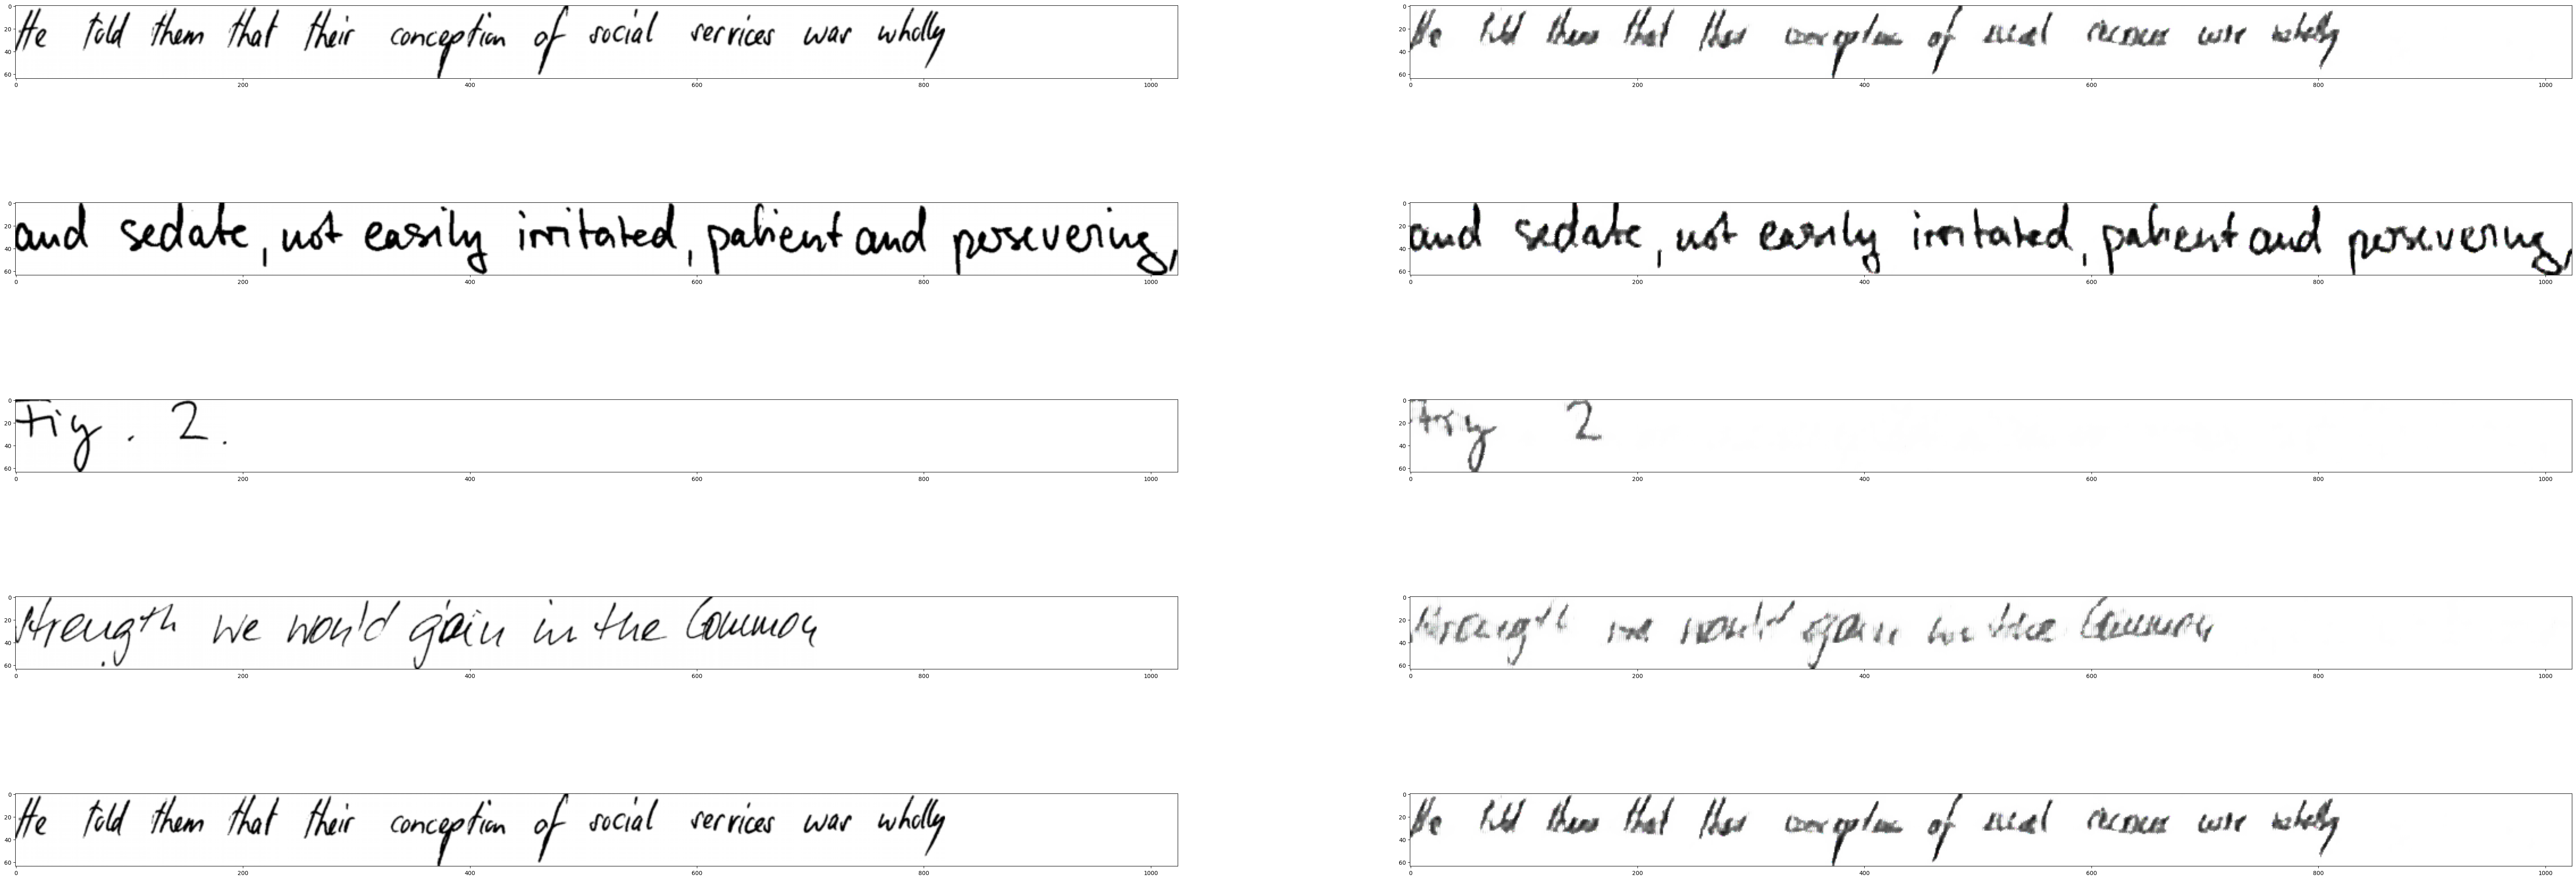

In [23]:
# Plot images 

n_examples = 5
fig, ax = plt.subplots(n_examples, 2, figsize=(80, 30))

# Generate outputs for a batch
with torch.no_grad():
  model.eval()
  model.to(device)
  batch = next(iter(dl_train))
  images, targets, _ = batch
  images = images.to(device)
  outputs = model(images.to(device))


for i in range(n_examples):
  idx = np.random.randint(0, images.shape[0])
  ax[i, 0].imshow(images[idx].detach().cpu().permute(1, 2, 0))
  ax[i, 1].imshow(outputs[idx].detach().cpu().permute(1, 2, 0))

In [26]:
# Get reconstruction error for a batch
total_loss = 0.0
criterion = nn.MSELoss()
with torch.no_grad():
  model.eval()
  model.to(device)
  for i, batch in enumerate(dl_train):
    images, targets, _ = batch
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    total_loss += loss.item()
    if i == 0:
      print(f'Loss: {loss.item()}')
      print(f'Images shape: {images.shape}')
      print(f'Outputs shape: {outputs.shape}')
      print(f'Mean loss: {total_loss / images.shape[0]}')
      break
    

Loss: 0.013304626569151878
Images shape: torch.Size([64, 3, 64, 1024])
Outputs shape: torch.Size([64, 3, 64, 1024])
Mean loss: 0.0002078847901429981


In [22]:
def get_reconstruction_error(model, dataset_name, data_loader, criterion):
  total_loss = 0.0
  with torch.no_grad():
    model.eval()
    model.to(device)
    for i, batch in enumerate(data_loader):
      images, targets, _ = batch
      images = images.to(device)
      outputs = (model(images) > 0.5).float()
      loss = criterion(outputs, images)
      total_loss += loss.item()
      
  return {
    "dataset": dataset_name, 
    "total_loss": total_loss,
    "reconstruction_error": total_loss / len(data_loader.dataset), 
    "n_samples": len(data_loader.dataset)
  }
  
# Get reconstruction error for IAM dataset
# reconstruction_error = get_reconstruction_error(model, "IAM", dl_train, criterion)


In [42]:
reconstruction_error

#{'dataset': 'IAM',
 #'total_loss': 1.351415242999792,
 #'reconstruction_error': 0.00020848738707185933,
 #'n_samples': 6482}

{'dataset': 'IAM',
 'total_loss': 2.490281054750085,
 'reconstruction_error': 0.0003841840565797724,
 'n_samples': 6482}

## Get all reconstruction errors for each dataset

In [15]:
dataloaders_tests = dict()

dataloaders_tests["IAM"] = read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/test.txt", src.data.data_utils.read_data_IAM, tokenizer)
dataloaders_tests["RIMES"] = read_dataset("../data/htr_datasets/RIMES/RIMES-2011-Lines/Images/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Transcriptions/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Sets/test.txt", src.data.data_utils.read_data_rimes, tokenizer)
dataloaders_tests["Saint_Gall"] = read_dataset("../data/htr_datasets/saint_gall/saintgalldb-v1.0/data/line_images_normalized/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/ground_truth/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/sets/test.txt", src.data.data_utils.read_data_saint_gall, tokenizer)
dataloaders_tests["Bentham"] = read_dataset("../data/htr_datasets/bentham/BenthamDatasetR0-GT/Images/Lines/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Transcriptions/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Partitions/test.txt", src.data.data_utils.read_data_bentham, tokenizer)
dataloaders_tests["Washington"] = read_dataset("../data/htr_datasets/washington/washingtondb-v1.0/data/line_images_normalized/", "../data/htr_datasets/washington/washingtondb-v1.0/ground_truth/", "../data/htr_datasets/washington/washingtondb-v1.0/sets/cv1/test.txt", src.data.data_utils.read_data_washington, tokenizer)
dataloaders_tests["ICFHR_2016"] = read_dataset("../data/htr_datasets/icfhr_2016/lines/", "../data/htr_datasets/icfhr_2016/transcriptions/", "../data/htr_datasets/icfhr_2016/partitions/test.txt", src.data.data_utils.read_data_icfhr_2016, tokenizer)
dataloaders_tests["Rodrigo"] = read_dataset("../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/images/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/text/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/partitions/test.txt", src.data.data_utils.read_data_rodrigo, tokenizer)



Files ['Seite0405', 'Seite0406', 'Seite0407', 'Seite0408', 'Seite0409', 'Seite0410', 'Seite0411', 'Seite0412', 'Seite0413', 'Seite0414', 'Seite0415', 'Seite0416', 'Seite0417', 'Seite0418', 'Seite0419', 'Seite0420', 'Seite0421', 'Seite0422', 'Seite0423', 'Seite0424', 'Seite0425', 'Seite0426', 'Seite0427', 'Seite0428', 'Seite0429', 'Seite0430', 'Seite0431', 'Seite0432', 'Seite0433', 'Seite0434', 'Seite0435', 'Seite0436', 'Seite0437', 'Seite0438', 'Seite0439', 'Seite0440', 'Seite0441', 'Seite0442', 'Seite0443', 'Seite0444', 'Seite0445', 'Seite0446', 'Seite0447', 'Seite0448', 'Seite0449', 'Seite0450', 'Seite0451', 'Seite0452', 'Seite0453', 'Seite0454']


In [23]:
reconstruction_errors = dict()
criterion = nn.MSELoss()

for dataset_name, data_loader in dataloaders_tests.items():
  reconstruction_errors[dataset_name] = get_reconstruction_error(model, dataset_name, data_loader, criterion)

reconstruction_errors

{'IAM': {'dataset': 'IAM',
  'total_loss': 3.6774235293269157,
  'reconstruction_error': 0.001261551811089851,
  'n_samples': 2915},
 'RIMES': {'dataset': 'RIMES',
  'total_loss': 0.8509573601186275,
  'reconstruction_error': 0.0010937755271447655,
  'n_samples': 778},
 'Saint_Gall': {'dataset': 'Saint_Gall',
  'total_loss': 1.503929428756237,
  'reconstruction_error': 0.0021271986262464456,
  'n_samples': 707},
 'Bentham': {'dataset': 'Bentham',
  'total_loss': 0.671915527433157,
  'reconstruction_error': 0.0007812971249222756,
  'n_samples': 860},
 'Washington': {'dataset': 'Washington',
  'total_loss': 0.19459525495767593,
  'reconstruction_error': 0.001193835919985742,
  'n_samples': 163},
 'ICFHR_2016': {'dataset': 'ICFHR_2016',
  'total_loss': 1.2758204191923141,
  'reconstruction_error': 0.0011945884074834401,
  'n_samples': 1068},
 'Rodrigo': {'dataset': 'Rodrigo',
  'total_loss': 10.355312682688236,
  'reconstruction_error': 0.0020669286791792888,
  'n_samples': 5010}}

In [34]:
reconstruction_error_rimes

# {'dataset': 'Rimes',
#  'total_loss': 0.5389745458960533,
#  'reconstruction_error': 0.000692769339198012,
#  'n_samples': 778}

{'dataset': 'Rimes',
 'total_loss': 0.5389745458960533,
 'reconstruction_error': 0.000692769339198012,
 'n_samples': 778}

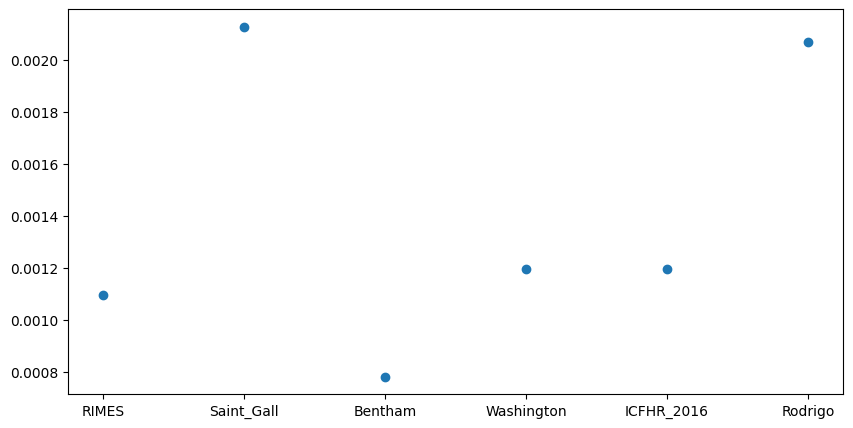

In [32]:
# Plot all reconstructions errors
import matplotlib.pyplot as plt

datasets = list(reconstruction_errors.keys())
reconstruction_error_values = [reconstruction_errors[dataset]["reconstruction_error"] for dataset in datasets]

plt.figure(figsize=(10, 5))
plt.scatter(datasets[1:], reconstruction_error_values[1:])

In [48]:
reconstruction_error_saint_gall

{'dataset': 'Saint Gall',
 'total_loss': 0.9865456745028496,
 'reconstruction_error': 0.002108003577997542,
 'n_samples': 468}

Images shape: torch.Size([64, 3, 64, 1024])
Outputs shape: torch.Size([64, 3, 64, 1024])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


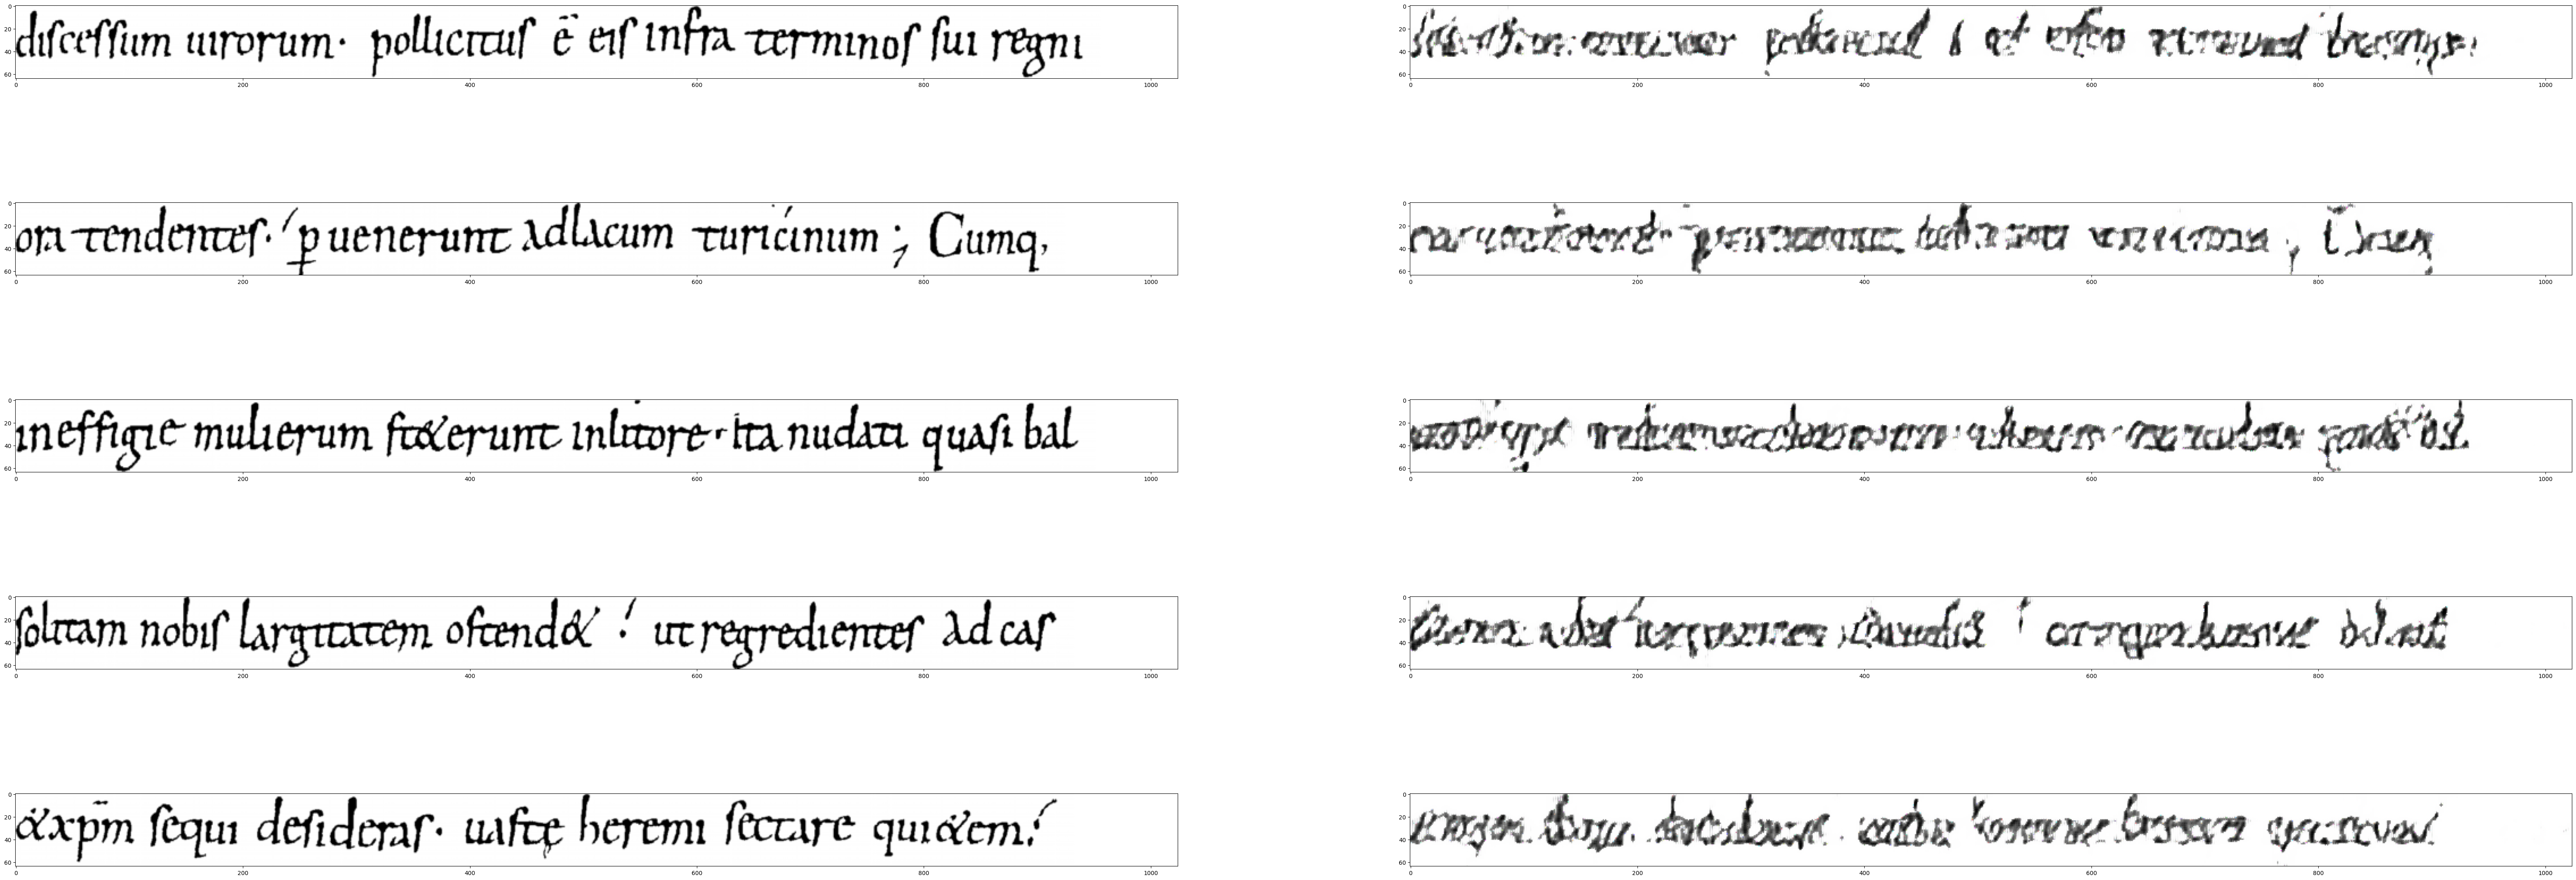

In [40]:
with torch.no_grad():
    model.eval()
    model.to(device)
    for i, batch in enumerate(dl_test):
      images, targets, _ = batch
      images = images.to(device)
      outputs = model(images)
      
      if i == 0:
        print(f'Images shape: {images.shape}')
        print(f'Outputs shape: {outputs.shape}')
        break

# Plot images and outputs for saint_gall
n_examples = 5

fig, ax = plt.subplots(n_examples, 2, figsize=(80, 30))

for i in range(n_examples):
  idx = np.random.randint(0, images.shape[0])
  ax[i, 0].imshow(images[idx].detach().cpu().permute(1, 2, 0))
  ax[i, 1].imshow(outputs[idx].detach().cpu().permute(1, 2, 0))
  


In [57]:
# Get for IAM all the reconstruction errors for every image in the dataset
with open("../data/htr_datasets/IAM/splits/train.txt", "r") as f:
  setfiles = f.read().splitlines()

read_data = src.data.data_utils.read_data_IAM
images_paths, words = read_data("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", setfiles)
htr_dataset_train = HTRDataset(images_paths, words, binarize=True, transform=v2.Compose([v2.ToTensor()]))
dl_train = torch.utils.data.DataLoader(
  htr_dataset_train, 
  batch_size=64, 
  shuffle=True, 
  num_workers=4, 
  pin_memory=True,
  collate_fn=lambda batch: src.data.data_utils.collate_fn(
    batch,
    img_size=(64,1024),
    text_transform=tokenizer.prepare_text
  )
)

error_images_IAM = []
for i, batch in enumerate(dl_train):
  with torch.no_grad():
    model.eval()
    model.to(device)
    images, targets, _ = batch
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    for i in range(images.shape[0]):
      error_images_IAM.append(loss.item())
      


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([transforms.ToImageTensor(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [60]:
# Get for Rimes all the reconstruction errors for every image in the test dataset
with open("../data/htr_datasets/RIMES/RIMES-2011-Lines/Sets/test.txt", "r") as f:
  setfiles = f.read().splitlines()
  
read_data = src.data.data_utils.read_data_rimes
images_paths, words = read_data("../data/htr_datasets/RIMES/RIMES-2011-Lines/Images/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Transcriptions/", setfiles)
htr_dataset_test = HTRDataset(images_paths, words, binarize=True, transform=v2.Compose([v2.ToTensor()]))
dl_test = torch.utils.data.DataLoader(htr_dataset_test, batch_size=64, shuffle=True, num_workers=4, pin_memory=True,collate_fn=lambda batch: src.data.data_utils.collate_fn(batch,img_size=(64,1024),text_transform=tokenizer.prepare_text))

error_images_rimes = []
for i, batch in enumerate(dl_test):
  with torch.no_grad():
    model.eval()
    model.to(device)
    images, targets, _ = batch
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    for i in range(images.shape[0]):
      error_images_rimes.append(loss.item())

In [61]:
# Get for Saint Gall all the reconstruction errors for every image in the test dataset
with open("../data/htr_datasets/saint_gall/saintgalldb-v1.0/sets/train.txt", "r") as f:
  setfiles = f.read().splitlines()
  
read_data = src.data.data_utils.read_data_saint_gall
images_paths, words = read_data("../data/htr_datasets/saint_gall/saintgalldb-v1.0/data/line_images_normalized/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/ground_truth/", setfiles)
htr_dataset_test = HTRDataset(images_paths, words, binarize=True, transform=v2.Compose([v2.ToTensor()]))
dl_test = torch.utils.data.DataLoader(htr_dataset_test, batch_size=64, shuffle=True, num_workers=4, pin_memory=True,collate_fn=lambda batch: src.data.data_utils.collate_fn(batch,img_size=(64,1024),text_transform=tokenizer.prepare_text))

error_images_saint_gall = []
for i, batch in enumerate(dl_test):
  with torch.no_grad():
    model.eval()
    model.to(device)
    images, targets, _ = batch
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    for i in range(images.shape[0]):
      error_images_saint_gall.append(loss.item())

In [107]:
# Get for Bentham all the reconstruction errors for every image in the test dataset
with open("../data/htr_datasets/bentham/BenthamDatasetR0-GT/Partitions/test.txt", "r") as f:
  setfiles = f.read().splitlines()
  
read_data = src.data.data_utils.read_data_bentham
images_paths, words = read_data("../data/htr_datasets/bentham/BenthamDatasetR0-GT/Images/Lines/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Transcriptions/", setfiles)
htr_dataset_test = HTRDataset(images_paths, words, binarize=True, transform=v2.Compose([v2.ToTensor()]))
dl_test_bentham = torch.utils.data.DataLoader(htr_dataset_test, batch_size=64, shuffle=True, num_workers=4, pin_memory=True,collate_fn=lambda batch: src.data.data_utils.collate_fn(batch,img_size=(64,1024),text_transform=tokenizer.prepare_text))

error_images_bentham = []
for i, batch in enumerate(dl_test_bentham):
  with torch.no_grad():
    model.eval()
    model.to(device)
    images, targets, _ = batch
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    for i in range(images.shape[0]):
      error_images_bentham.append(loss.item())

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([transforms.ToImageTensor(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [108]:
# Get for Rodrigo all the reconstruction errors for every image in the test dataset

htr_dataset_test = HTRDataset(images_paths, words, binarize=True, transform=v2.Compose([v2.ToTensor()]))
dl_test_rodrigo = torch.utils.data.DataLoader(htr_dataset_test, batch_size=64, shuffle=True, num_workers=4, pin_memory=True,collate_fn=lambda batch: src.data.data_utils.collate_fn(batch,img_size=(64,1024),text_transform=tokenizer.prepare_text))

error_images_rodrigo = []
for i, batch in enumerate(dl_test_rodrigo):
  with torch.no_grad():
    model.eval()
    model.to(device)
    images, targets, _ = batch
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    for i in range(images.shape[0]):
      error_images_rodrigo.append(loss.item())

In [109]:
# Get for ICFHR2016 all the reconstruction errors for every image in the test dataset


htr_dataset_test = HTRDataset(images_paths, words, binarize=True, transform=v2.Compose([v2.ToTensor()]))

dl_test_icfhr = torch.utils.data.DataLoader(htr_dataset_test, batch_size=64, shuffle=True, num_workers=4, pin_memory=True,collate_fn=lambda batch: src.data.data_utils.collate_fn(batch,img_size=(64,1024),text_transform=tokenizer.prepare_text))

error_images_icfhr2016 = []

for i, batch in enumerate(dl_test_icfhr):
  with torch.no_grad():
    model.eval()
    model.to(device)
    images, targets, _ = batch
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    for i in range(images.shape[0]):
      error_images_icfhr2016.append(loss.item())
      


Files ['Seite0405', 'Seite0406', 'Seite0407', 'Seite0408', 'Seite0409', 'Seite0410', 'Seite0411', 'Seite0412', 'Seite0413', 'Seite0414', 'Seite0415', 'Seite0416', 'Seite0417', 'Seite0418', 'Seite0419', 'Seite0420', 'Seite0421', 'Seite0422', 'Seite0423', 'Seite0424', 'Seite0425', 'Seite0426', 'Seite0427', 'Seite0428', 'Seite0429', 'Seite0430', 'Seite0431', 'Seite0432', 'Seite0433', 'Seite0434', 'Seite0435', 'Seite0436', 'Seite0437', 'Seite0438', 'Seite0439', 'Seite0440', 'Seite0441', 'Seite0442', 'Seite0443', 'Seite0444', 'Seite0445', 'Seite0446', 'Seite0447', 'Seite0448', 'Seite0449', 'Seite0450', 'Seite0451', 'Seite0452', 'Seite0453', 'Seite0454']


In [110]:
# Get for washington all the reconstruction errors for every image in the test dataset


htr_dataset_test = HTRDataset(images_paths, words, binarize=True, transform=v2.Compose([v2.ToTensor()]))

dl_test_washington = torch.utils.data.DataLoader(htr_dataset_test, batch_size=64, shuffle=True, num_workers=4, pin_memory=True,collate_fn=lambda batch: src.data.data_utils.collate_fn(batch,img_size=(64,1024),text_transform=tokenizer.prepare_text))

error_images_washington = []

for i, batch in enumerate(dl_test_washington):
  with torch.no_grad():
    model.eval()
    model.to(device)
    images, targets, _ = batch
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    for i in range(images.shape[0]):
      error_images_washington.append(loss.item())

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([transforms.ToImageTensor(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


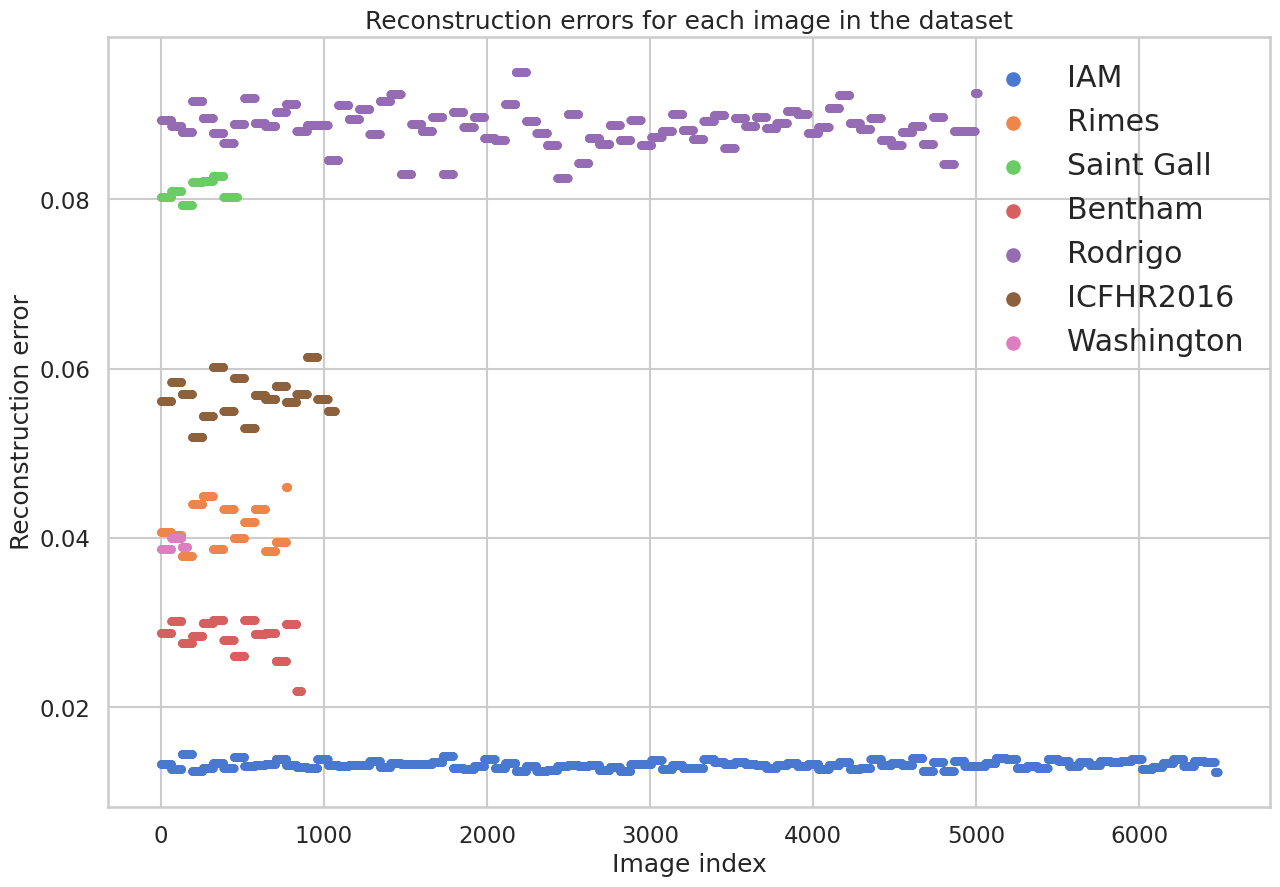

In [102]:
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set(style="whitegrid")

# Make the plot bigger and the letters more readable bigger

# Initialize the figure
plt.figure(figsize=(15, 10))

sns.set_context("talk")


# Adjust the space between subplots
plt.subplots_adjust(hspace=5.)

# Plot the scatter plots with Seaborn's color palette
# Choose the palette with 6 different colors that can be easily distinguished
palette = sns.color_palette("muted", 7)

plt.scatter(range(len(error_images)), error_images, marker='.', color=palette[0])
plt.scatter(range(len(error_images_rimes)), error_images_rimes, marker='.', color=palette[1])
plt.scatter(range(len(error_images_saint_gall)), error_images_saint_gall, marker='.', color=palette[2])
plt.scatter(range(len(error_images_bentham)), error_images_bentham, marker='.', color=palette[3])
plt.scatter(range(len(error_images_rodrigo)), error_images_rodrigo, marker='.', color=palette[4])
plt.scatter(range(len(error_images_icfhr2016)), error_images_icfhr2016, marker='.', color=palette[5])
plt.scatter(range(len(error_images_washington)), error_images_washington, marker='.', color=palette[6])


# Set legend

# Make the legend more readable
plt.legend(["IAM", "Rimes", "Saint Gall", "Bentham", "Rodrigo", "ICFHR2016", "Washington"], loc='upper right', fontsize='large', markerscale=2)

# Make bigger the markers in the legend

# Set titles and labels
plt.title("Reconstruction errors for each image in the dataset")
plt.xlabel("Image index")
plt.ylabel("Reconstruction error")

# Save image in pdf format
plt.savefig("reconstruction_errors2.pdf")

# Show the plot
plt.show()




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


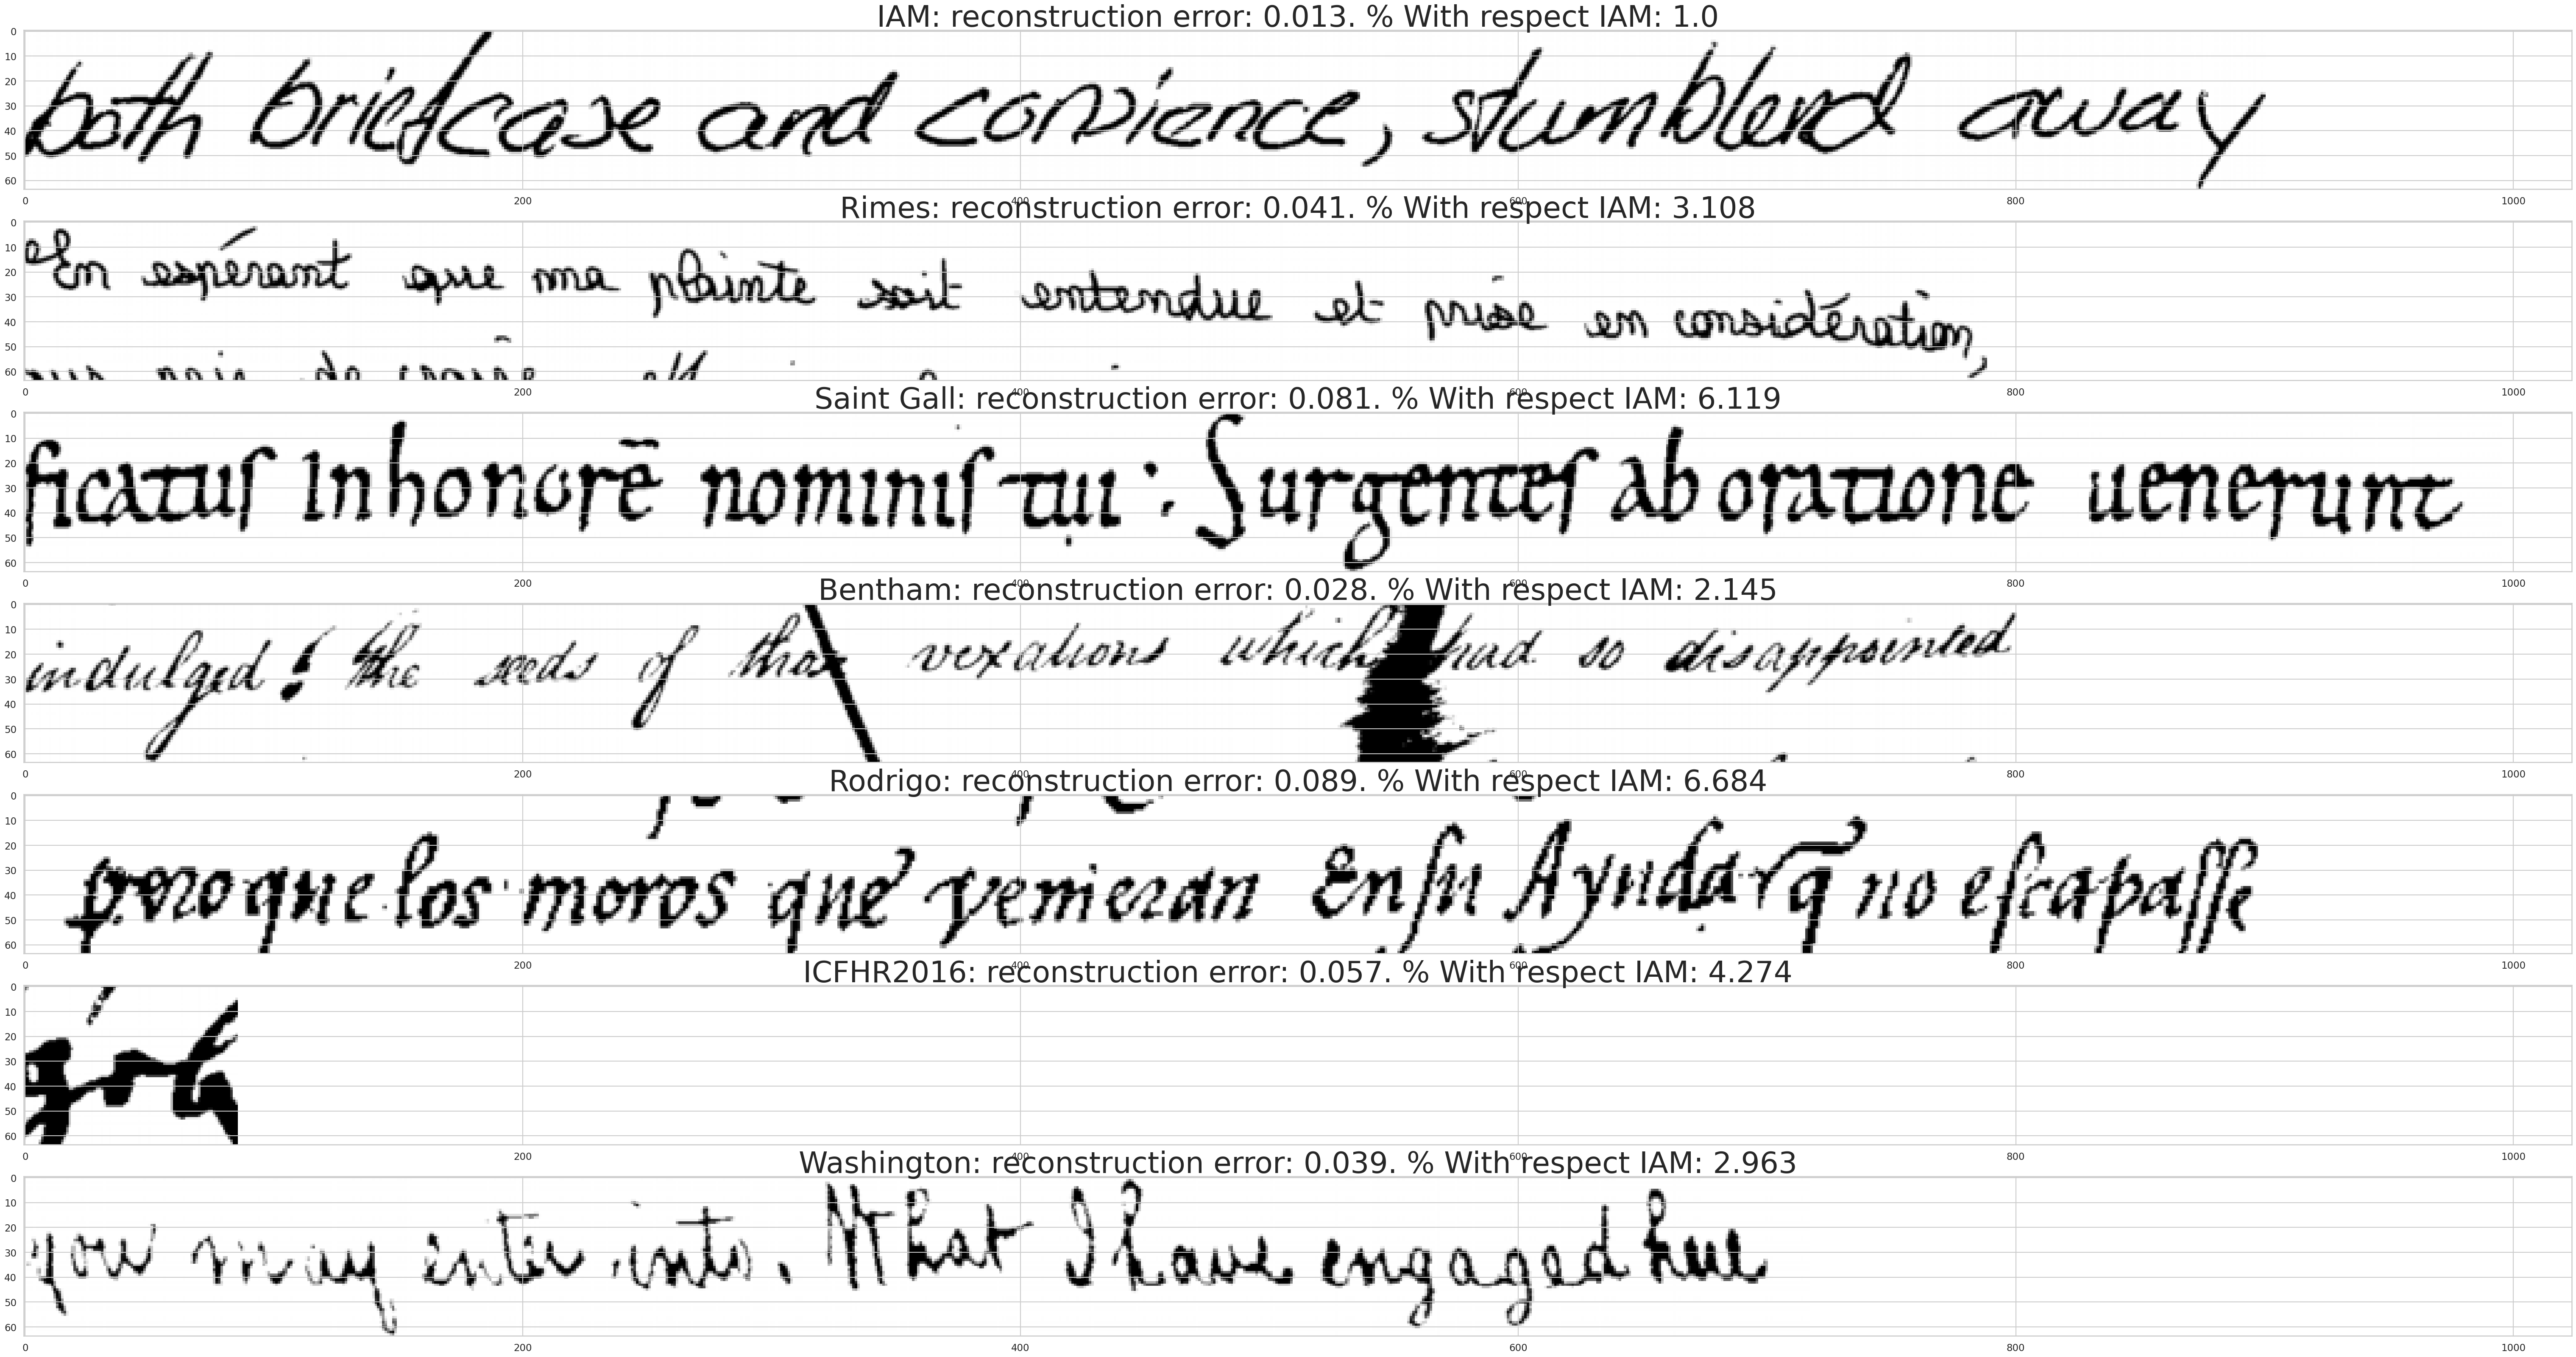

In [124]:
# Plot one image per dataset with each dataloader
n_examples = 1

fig, ax = plt.subplots(7, 1, figsize=(100, 40))

# IAM
images = next(iter(dl_train))[0]
for i in range(n_examples):
  idx = np.random.randint(0, images.shape[0])
  ax[0].imshow(images[idx].detach().cpu().permute(1, 2, 0))
  ax[0].set_title(f'IAM: reconstruction error: {round(np.mean(error_images_IAM), 3)}. % With respect IAM: {round(np.mean(error_images_IAM) / np.mean(error_images_IAM), 3)}', fontsize=50)
  
images = next(iter(dl_test_rimes))[0]
# Rimes
for i in range(n_examples):
  idx = np.random.randint(0, images.shape[0])
  ax[1].imshow(images[idx].detach().cpu().permute(1, 2, 0))
  ax[1].set_title(f'Rimes: reconstruction error: {round(np.mean(error_images_rimes), 3)}. % With respect IAM: {round(np.mean(error_images_rimes) / np.mean(error_images_IAM), 3)}', fontsize=50)

images = next(iter(dl_test_saint_gall))[0]
# Saint Gall
for i in range(n_examples):
  idx = np.random.randint(0, images.shape[0])
  ax[2].imshow(images[idx].detach().cpu().permute(1, 2, 0))
  ax[2].set_title(f'Saint Gall: reconstruction error: {round(np.mean(error_images_saint_gall), 3)}. % With respect IAM: {round(np.mean(error_images_saint_gall) / np.mean(error_images_IAM), 3)}', fontsize=50)

images = next(iter(dl_test_bentham))[0]
# Bentham
for i in range(n_examples):
  idx = np.random.randint(0, images.shape[0])
  ax[3].imshow(images[idx].detach().cpu().permute(1, 2, 0))
  ax[3].set_title(f'Bentham: reconstruction error: {round(np.mean(error_images_bentham), 3)}. % With respect IAM: {round(np.mean(error_images_bentham) / np.mean(error_images_IAM), 3)}', fontsize=50)

images = next(iter(dl_test_rodrigo))[0]
# Rodrigo
for i in range(n_examples):
  idx = np.random.randint(0, images.shape[0])
  ax[4].imshow(images[idx].detach().cpu().permute(1, 2, 0))
  ax[4].set_title(f'Rodrigo: reconstruction error: {round(np.mean(error_images_rodrigo), 3)}. % With respect IAM: {round(np.mean(error_images_rodrigo) / np.mean(error_images_IAM), 3)}', fontsize=50)
  
images = next(iter(dl_test_icfhr))[0]
# ICFHR2016
for i in range(n_examples):
  idx = np.random.randint(0, images.shape[0])
  ax[5].imshow(images[idx].detach().cpu().permute(1, 2, 0))
  ax[5].set_title(f'ICFHR2016: reconstruction error: {round(np.mean(error_images_icfhr2016), 3)}. % With respect IAM: {round(np.mean(error_images_icfhr2016) / np.mean(error_images_IAM), 3)}', fontsize=50)
  
images = next(iter(dl_test_washington))[0]
# Washington
for i in range(n_examples):
  idx = np.random.randint(0, images.shape[0])
  ax[6].imshow(images[idx].detach().cpu().permute(1, 2, 0))
  # Set titles and labels gigantic
  ax[6].set_title(f'Washington: reconstruction error: {round(np.mean(error_images_washington), 3)}. % With respect IAM: {round(np.mean(error_images_washington) / np.mean(error_images_IAM), 3)}', fontsize=50)
  


  


Text(0, 0.5, 'CER')

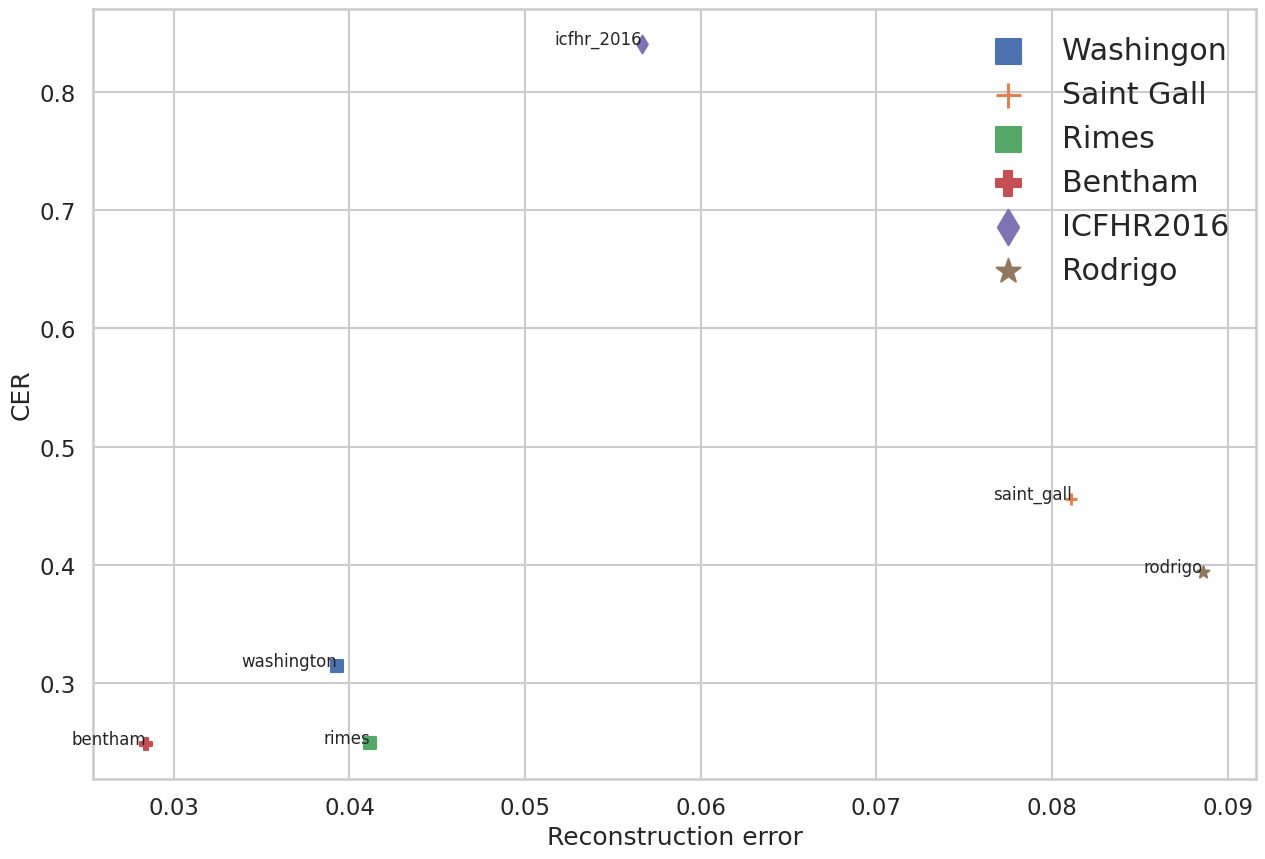

In [136]:
test_cers_ood = {
  "washington": (0.3146, np.mean(error_images_washington)),
  "saint_gall": (0.456, np.mean(error_images_saint_gall)),
  "rimes": (0.2498, np.mean(error_images_rimes)),
  "bentham": (0.2487, np.mean(error_images_bentham)),
  "icfhr_2016": (0.8404, np.mean(error_images_icfhr2016)),
  "rodrigo":(0.3944, np.mean(error_images_rodrigo))
}

plt.figure(figsize=(15, 10))

# Plot CER in OOD vs Reconstruction error
# plt.scatter([v[0] for k, v in test_cers_ood.items()], [v[1] for k, v in test_cers_ood.items()], marker='o')
for dataset, (cer, error) in test_cers_ood.items():
  plt.scatter(error, cer, marker=np.random.choice(['o', 'x', '+', 'v', '^', '<', '>', 's', 'd', 'p', 'P', '*']))
  plt.text(error, cer, dataset, fontsize=12, ha='right')
plt.legend(["Washingon", "Saint Gall", "Rimes", "Bentham", "ICFHR2016", "Rodrigo"], loc='upper right', fontsize='large', markerscale=2)
plt.xlabel("Reconstruction error")
plt.ylabel("CER")


## Convolutional Autoencoder for each dataset (Anomaly Detection, AD)

In [25]:
# Generic functions for reading data and create a dataloader

def read_dataset(images_path, sequences_path, split_path, read_data, tokenizer, transform=v2.Compose([v2.ToTensor()])):
  with open(split_path, "r") as f:
    setfiles = f.read().splitlines()
  
  images_paths, words = read_data(images_path, sequences_path, setfiles)
  htr_dataset = HTRDataset(images_paths, words, binarize=True, transform=transform)

  # Create dataloader for iam
  dl = torch.utils.data.DataLoader(
    htr_dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=8, 
    pin_memory=True,
    collate_fn=lambda batch: src.data.data_utils.collate_fn(
      batch,
      img_size=(64,1024),
      text_transform=tokenizer.prepare_text
    )
  )
  return dl

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [9]:
tokenizer = src.data.components.tokenizers.CharTokenizer(model_name="char_tokenizer", vocab_file="../data/vocab.txt")

transforms_train = v2.Compose(
  [
    torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.ElasticTransform(5.0, 5.0)], p=0.5),
    torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.RandomAffine(degrees=1, translate=(0.01, 0.05), shear=[-1, 1, -1, 1], fill=255)], p=0.5),
    torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.RandomPerspective(distortion_scale=0.1, p=1.0, fill=255)], p=0.5),
    torchvision.transforms.v2.ToTensor()
  ]
)


VOCAB SIZE TOKENIZER: 94
COMPLETE VOCAB: {'[BOS]': 0, '[EOS]': 1, '[PAD]': 2, '[UNK]': 3, ' ': 4, '!': 5, '"': 6, '#': 7, '%': 8, '&': 9, "'": 10, '(': 11, ')': 12, '*': 13, '+': 14, ',': 15, '-': 16, '.': 17, '/': 18, '0': 19, '1': 20, '2': 21, '3': 22, '4': 23, '5': 24, '6': 25, '7': 26, '8': 27, '9': 28, ':': 29, ';': 30, '<': 31, '=': 32, '>': 33, '?': 34, 'A': 35, 'B': 36, 'C': 37, 'D': 38, 'E': 39, 'F': 40, 'G': 41, 'H': 42, 'I': 43, 'J': 44, 'K': 45, 'L': 46, 'M': 47, 'N': 48, 'O': 49, 'P': 50, 'Q': 51, 'R': 52, 'S': 53, 'T': 54, 'U': 55, 'V': 56, 'W': 57, 'X': 58, 'Y': 59, 'Z': 60, '[': 61, ']': 62, '_': 63, 'a': 64, 'b': 65, 'c': 66, 'd': 67, 'e': 68, 'f': 69, 'g': 70, 'h': 71, 'i': 72, 'j': 73, 'k': 74, 'l': 75, 'm': 76, 'n': 77, 'o': 78, 'p': 79, 'q': 80, 'r': 81, 's': 82, 't': 83, 'u': 84, 'v': 85, 'w': 86, 'x': 87, 'y': 88, 'z': 89, '{': 90, '}': 91, '£': 92, '€': 93}


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Get data for each dataset and each split

In [26]:
train_datasets = dict({
  'iam': read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/train.txt", src.data.data_utils.read_data_IAM, tokenizer, transform=transforms_train),
  'rimes': read_dataset("../data/htr_datasets/RIMES/RIMES-2011-Lines/Images/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Transcriptions/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Sets/train.txt", src.data.data_utils.read_data_rimes, tokenizer, transform=transforms_train),
  'washingon': read_dataset("../data/htr_datasets/washington/washingtondb-v1.0/data/line_images_normalized/", "../data/htr_datasets/washington/washingtondb-v1.0/ground_truth/", "../data/htr_datasets/washington/washingtondb-v1.0/sets/cv1/train.txt", src.data.data_utils.read_data_washington, tokenizer, transform=transforms_train),
  'saint_gall': read_dataset("../data/htr_datasets/saint_gall/saintgalldb-v1.0/data/line_images_normalized/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/ground_truth/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/sets/train.txt", src.data.data_utils.read_data_saint_gall, tokenizer, transform=transforms_train),
  'bentham': read_dataset("../data/htr_datasets/bentham/BenthamDatasetR0-GT/Images/Lines/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Transcriptions/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Partitions/train.txt", src.data.data_utils.read_data_bentham, tokenizer, transform=transforms_train),
  'rodrigo': read_dataset("../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/images/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/text/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/partitions/train.txt", src.data.data_utils.read_data_rodrigo, tokenizer, transform=transforms_train),
  'icfhr_2016': read_dataset("../data/htr_datasets/icfhr_2016/lines/", "../data/htr_datasets/icfhr_2016/transcriptions/", "../data/htr_datasets/icfhr_2016/partitions/train.txt", src.data.data_utils.read_data_icfhr_2016, tokenizer, transform=transforms_train),
})

val_datasets = dict({
  'iam': read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/val.txt", src.data.data_utils.read_data_IAM, tokenizer),
  'rimes': read_dataset("../data/htr_datasets/RIMES/RIMES-2011-Lines/Images/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Transcriptions/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Sets/val.txt", src.data.data_utils.read_data_rimes, tokenizer),
  'washingon': read_dataset("../data/htr_datasets/washington/washingtondb-v1.0/data/line_images_normalized/", "../data/htr_datasets/washington/washingtondb-v1.0/ground_truth/", "../data/htr_datasets/washington/washingtondb-v1.0/sets/cv1/val.txt", src.data.data_utils.read_data_washington, tokenizer),
  'saint_gall': read_dataset("../data/htr_datasets/saint_gall/saintgalldb-v1.0/data/line_images_normalized/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/ground_truth/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/sets/val.txt", src.data.data_utils.read_data_saint_gall, tokenizer),
  'bentham': read_dataset("../data/htr_datasets/bentham/BenthamDatasetR0-GT/Images/Lines/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Transcriptions/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Partitions/val.txt", src.data.data_utils.read_data_bentham, tokenizer),
  'rodrigo': read_dataset("../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/images/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/text/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/partitions/val.txt", src.data.data_utils.read_data_rodrigo, tokenizer),
  'icfhr_2016': read_dataset("../data/htr_datasets/icfhr_2016/lines/", "../data/htr_datasets/icfhr_2016/transcriptions/", "../data/htr_datasets/icfhr_2016/partitions/val.txt", src.data.data_utils.read_data_icfhr_2016, tokenizer),
})

test_datasets = dict({
  'iam': read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/test.txt", src.data.data_utils.read_data_IAM, tokenizer),
  'rimes': read_dataset("../data/htr_datasets/RIMES/RIMES-2011-Lines/Images/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Transcriptions/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Sets/test.txt", src.data.data_utils.read_data_rimes, tokenizer),
  'washingon': read_dataset("../data/htr_datasets/washington/washingtondb-v1.0/data/line_images_normalized/", "../data/htr_datasets/washington/washingtondb-v1.0/ground_truth/", "../data/htr_datasets/washington/washingtondb-v1.0/sets/cv1/test.txt", src.data.data_utils.read_data_washington, tokenizer),
  'saint_gall': read_dataset("../data/htr_datasets/saint_gall/saintgalldb-v1.0/data/line_images_normalized/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/ground_truth/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/sets/test.txt", src.data.data_utils.read_data_saint_gall, tokenizer),
  'bentham': read_dataset("../data/htr_datasets/bentham/BenthamDatasetR0-GT/Images/Lines/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Transcriptions/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Partitions/test.txt", src.data.data_utils.read_data_bentham, tokenizer),
  'rodrigo': read_dataset("../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/images/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/text/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/partitions/test.txt", src.data.data_utils.read_data_rodrigo, tokenizer),
  'icfhr_2016': read_dataset("../data/htr_datasets/icfhr_2016/lines/", "../data/htr_datasets/icfhr_2016/transcriptions/", "../data/htr_datasets/icfhr_2016/partitions/test.txt", src.data.data_utils.read_data_icfhr_2016, tokenizer),
})

Files ['Seite0001', 'Seite0002', 'Seite0003', 'Seite0004', 'Seite0005', 'Seite0007', 'Seite0008', 'Seite0009', 'Seite0010', 'Seite0011', 'Seite0012', 'Seite0013', 'Seite0014', 'Seite0015', 'Seite0016', 'Seite0017', 'Seite0021', 'Seite0022', 'Seite0023', 'Seite0024', 'Seite0025', 'Seite0026', 'Seite0027', 'Seite0028', 'Seite0029', 'Seite0030', 'Seite0031', 'Seite0032', 'Seite0033', 'Seite0034', 'Seite0035', 'Seite0036', 'Seite0037', 'Seite0038', 'Seite0039', 'Seite0040', 'Seite0041', 'Seite0042', 'Seite0043', 'Seite0044', 'Seite0045', 'Seite0046', 'Seite0047', 'Seite0048', 'Seite0049', 'Seite0050', 'Seite0051', 'Seite0052', 'Seite0053', 'Seite0054', 'Seite0055', 'Seite0056', 'Seite0057', 'Seite0058', 'Seite0059', 'Seite0060', 'Seite0061', 'Seite0062', 'Seite0063', 'Seite0064', 'Seite0065', 'Seite0066', 'Seite0067', 'Seite0068', 'Seite0069', 'Seite0070', 'Seite0071', 'Seite0072', 'Seite0073', 'Seite0074', 'Seite0075', 'Seite0076', 'Seite0077', 'Seite0078', 'Seite0079', 'Seite0080', 'Seit

In [27]:
model = AE()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import tqdm
from tqdm import tqdm

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
  
print(f'The model has {count_parameters(model):,} trainable parameters')



The model has 33,782,467 trainable parameters


In [28]:
def train_conv_AE(model, dataset, train_dl, val_dl, test_dl, criterion, optimizer, device, n_epochs=100):
  best_loss_val = 1e10
  print(f'Device: {device}')
  model = model.to(device)
  for epoch in range(n_epochs):
    print(f'Epoch {epoch}')
    total_loss_epoch = 0.0
    model.train()
    for i, batch in tqdm(enumerate(train_dl), total=len(train_dl)):
      images, targets, _ = batch
      images = images.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, images)
      total_loss_epoch += loss.item()

      loss.backward()
      optimizer.step()

      # if i % 1000 == 0:
      #   print(f'Epoch {epoch}, Loss: {loss.item()}')
        
    print(f'Epoch {epoch}, Loss: {loss.item()}. Total loss: {total_loss_epoch}')
    
    # Validation
    model.eval()
    total_loss_val = 0.0
    with torch.no_grad():
      for i, batch in enumerate(val_dl):
        images, targets, _ = batch
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        total_loss_val += loss.item()
        
    print(f'Validation loss: {total_loss_val}')
    
    if best_loss_val > total_loss_val and epoch > 0:
      best_loss_val = total_loss_val
      torch.save(model.state_dict(), f'../checkpoints/best_ae_{dataset}.ckpt')
      print('Model saved')
      

In [29]:
# Create model for each dataset
models = dict({
  'iam': AE(),
  'rimes': AE(),
  'washingon': AE(),
  'saint_gall': AE(),
  'bentham': AE(),
  'rodrigo': AE(),
  'icfhr_2016': AE()
})



In [30]:
# Train model for IAM
train_conv_AE(models['iam'], 'iam', train_datasets['iam'], val_datasets['iam'], test_datasets['iam'], criterion, optimizer, device, n_epochs=100)
# Train model for each dataset

Device: cuda
Epoch 0


100%|██████████| 102/102 [03:57<00:00,  2.33s/it]

Epoch 0, Loss: 0.23336322605609894. Total loss: 23.785350531339645


Validation loss: 3.7468549758195877
Epoch 1


100%|██████████| 102/102 [04:04<00:00,  2.39s/it]

Epoch 1, Loss: 0.2337801456451416. Total loss: 23.785762891173363


Validation loss: 3.7471271753311157
Model saved
Epoch 2


100%|██████████| 102/102 [04:05<00:00,  2.40s/it]

Epoch 2, Loss: 0.23399554193019867. Total loss: 23.787398025393486


Validation loss: 3.747622638940811
Epoch 3


100%|██████████| 102/102 [03:54<00:00,  2.29s/it]

Epoch 3, Loss: 0.23198944330215454. Total loss: 23.78718400001526


Validation loss: 3.747122496366501
Model saved
Epoch 4


100%|██████████| 102/102 [03:53<00:00,  2.29s/it]

Epoch 4, Loss: 0.23280112445354462. Total loss: 23.78615140914917


Validation loss: 3.7473277896642685
Epoch 5


100%|██████████| 102/102 [03:49<00:00,  2.25s/it]

Epoch 5, Loss: 0.233319953083992. Total loss: 23.784617215394974


Validation loss: 3.7485668808221817
Epoch 6


100%|██████████| 102/102 [04:06<00:00,  2.42s/it]

Epoch 6, Loss: 0.23252037167549133. Total loss: 23.784819066524506


Validation loss: 3.7477857619524
Epoch 7


100%|██████████| 102/102 [03:54<00:00,  2.29s/it]

Epoch 7, Loss: 0.23361022770404816. Total loss: 23.785337522625923


Validation loss: 3.7472296059131622
Epoch 8


100%|██████████| 102/102 [03:41<00:00,  2.17s/it]

Epoch 8, Loss: 0.23415632545948029. Total loss: 23.787197038531303


Validation loss: 3.7469561398029327
Model saved
Epoch 9


100%|██████████| 102/102 [03:50<00:00,  2.26s/it]

Epoch 9, Loss: 0.23358099162578583. Total loss: 23.78807957470417


Validation loss: 3.7476656436920166
Epoch 10


100%|██████████| 102/102 [03:47<00:00,  2.23s/it]

Epoch 10, Loss: 0.23400412499904633. Total loss: 23.7865858823061


Validation loss: 3.7470428496599197
Epoch 11


 84%|████████▍ | 86/102 [03:27<00:25,  1.62s/it]